<a href="https://colab.research.google.com/github/KonstantinLihota/Image_Caption/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22IC2_0_pynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# План выполнения
1) Загрузить данные, выкинуть из них лишнние слова, и знаки препинания

2) Токенизовать с помощью bert

3) Написать сеть без внимания используя все ту же cnn сеть. 

4) Проверить качество

5) Добавить внимание

6) Добавить другую cnn

7) Сделать бота 

## Загрузка данных и чистка 

In [1]:
device ='cuda:0'
#device ='cpu'

In [2]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/gdrive/MyDrive/handout.tar'

Mounted at /content/gdrive


In [3]:
import numpy as np
import json
import tarfile
tar = tarfile.open(DATA_PATH, 'r')
tar.extractall()
tar.close()

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [4]:
!pip install transformers
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 636 kB 56.6 MB/s 
     |████████████████████████████████| 3.3 MB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

In [5]:
import nltk
nltk.download('punkt')
from itertools import chain
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WordPunctTokenizer
from torchtext.legacy.data import Field, BucketIterator


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
from torch.utils.data import Dataset, random_split
import torch
from gensim.corpora.dictionary import Dictionary
class Tokenizer():
    def __init__(self, text,tokenizer = tokenizer,  count_word = 5):
      self.len_vocab = set()
      self.text = text
      self.count_word= count_word
      self.my_vocab = None
    def Vocab_size(self):
      return self.my_vocab.num_pos
    def Vocab_count(self):
      wordlist =[]
      [[wordlist.append(word_tokenize(sent)) for sent in description] for description in self.text] #----------------------------------------
      return Counter(chain(*wordlist))



    def tokeniz(self):
      
      vocab_count = self.Vocab_count()
      tokens = []

      my_vocab = Dictionary([list(vocab_count)])
      for description in self.text: #----------------------------------------
         batch =[]
         for sent in description:
           clear_sent =[]
           for word in word_tokenize(sent):
             if vocab_count.setdefault(word)>self.count_word:
               clear_sent.append(word)
               self.len_vocab.add(vocab_count.setdefault(word)) 

           batch.append(tokenizer(' '.join(clear_sent) ))
         tokens.append(batch)

      return tokens


In [7]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

In [8]:
img_codes[0]

array([0.3659946 , 0.2016555 , 0.9245725 , ..., 0.00344942, 0.99817497,
       1.1091837 ], dtype=float32)

In [9]:
tok = Tokenizer(captions).tokeniz()

In [10]:
tok[0]

[{'input_ids': [101, 2111, 6023, 1999, 2019, 2330, 3006, 2005, 11546, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2019, 2330, 3006, 2440, 1997, 2111, 1998, 18526, 1997, 11546, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2111, 2024, 6023, 2012, 2019, 2330, 2250, 3965, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2312, 18526, 1997, 25659, 2015, 1998, 14629, 2012, 1037, 10789, 7254, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2111, 4497, 2005, 11546, 2066, 25659, 2015, 1998, 14629, 2012, 2019, 2330, 2250, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}]

In [11]:
from torch.utils.data import Dataset, random_split
import torch
from gensim.corpora.dictionary import Dictionary
class  PreprocessingDataset(Dataset):

  def __init__(self, text,img_codes,tokenizer = tokenizer,  tokeniz = tok ):
      self.tokenized = tokeniz

      self.text =text
      self.img_codes =img_codes


  def __getitem__(self,index):
         return {"tokenized": self.tokenized[:][index] , "img_codes": self.img_codes[index]}
  def __len__(self):
     return len(self.text)

dataset  = PreprocessingDataset(captions ,img_codes)

train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

In [12]:
train_data.dataset.tokenized[0]

[{'input_ids': [101, 2111, 6023, 1999, 2019, 2330, 3006, 2005, 11546, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2019, 2330, 3006, 2440, 1997, 2111, 1998, 18526, 1997, 11546, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2111, 2024, 6023, 2012, 2019, 2330, 2250, 3965, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2312, 18526, 1997, 25659, 2015, 1998, 14629, 2012, 1037, 10789, 7254, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 2111, 4497, 2005, 11546, 2066, 25659, 2015, 1998, 14629, 2012, 2019, 2330, 2250, 3006, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}]

In [13]:
train_data.dataset.img_codes[0]

array([0.3659946 , 0.2016555 , 0.9245725 , ..., 0.00344942, 0.99817497,
       1.1091837 ], dtype=float32)

In [14]:
len(train_data.indices)

94629

In [15]:
 a = np.array(train_data.dataset.tokenized)[0]


In [16]:
from torch.utils.data import Sampler
import random
from torch.utils.data import DataLoader
class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=64):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices

        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

def get_padded(values):
    padded= []
    max_len = 15


    for sent in values:
        sent =  sent['input_ids']
        if len(sent)> max_len:
          padded.append(np.array(sent[:max_len-1]+[102]))


        else:
          padded.append(np.array(sent + [0]*(max_len-len(sent))))


    return np.array(padded)

def collate_fn(batch):

    inputs = []
    labels = []
    bh =[]
    for elem in batch:

        inputs.append(elem['tokenized'])
        labels.append(elem['img_codes'])


    inp =[]
    mask_a =[]
    for i in inputs:

        inp.append(get_padded(i) )## padded inputs
        
        l = len(inp[-1][0])
  
        mask_a.append(torch.ones(l).numpy())


    return {"inputs": torch.tensor(inp).to(device),'mask': torch.tensor(mask_a).to(device), "img_codes": torch.FloatTensor(labels).to(device) }

train_loader = DataLoader(train_data,  batch_size=32,collate_fn=collate_fn)
valid_loader = DataLoader(valid_data,  batch_size=32,collate_fn=collate_fn)
test_loader = DataLoader(test_data,  batch_size=32, collate_fn=collate_fn)

In [54]:
for i in train_loader:
  #print(i)
  break



In [ ]:
i['inputs'][0]

tensor([[  101,  1037,  2193,  1997,  2111,  2006,  1037,  2795,  2007,  2116,
          7877,   102,     0,     0,     0],
        [  101,  1037,  2158, 13053,  4511,  2046,  1037,  3221,  2012,  1037,
          2795,  2007,  2195,  2111,   102],
        [  101,  1037,  2158,  2008,  2003,  3173,  1037,  4511,  5835,  2379,
          1037,  2795,  1012,   102,     0],
        [  101,  1037,  2795,  1999,  1037,  4825,  2008,  2038,  2195,  3080,
          2111,  8901,  1998,  1037,   102],
        [  101,  1037,  2158, 13053,  4511,  2046,  1037,  3221,  3564,  2006,
          1037,  2795,   102,     0,     0]])

## Архитектура

In [17]:
embed= model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
 
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)

        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [52]:
class CaptionNet(nn.Module):
    def __init__(self, hidden_dim,attention_dim = 256, cnn_feature_size=2048, dropout=0.3, n_layers=2, bidirectional=False,
                 embedding_dim= 768, vocab_size=tokenizer.vocab_size, pretrain_embeded= embed, num_pixel = 32 ):
        super(self.__class__, self).__init__()
        '''
        hidden_dim: размерность скрытых состояний rnn сети 
        cnn_feature_size: размерность выхода из энкодера картинки
        embedding_dim: размернсть эмбединга 
        n_layers количество слоев в rnn сети
        '''
        enc = cnn_feature_size//num_pixel
        self.num_pixel = num_pixel 
       
        self.attention = Attention(enc  ,hidden_dim, attention_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        
        self.embedding_dim = embedding_dim
        self.f_beta = nn.Linear(hidden_dim, enc)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Sequential(                # cлой для инициализации hidden state rnn сети
            nn.Linear(cnn_feature_size, hidden_dim))
        
        self.init_c = nn.Sequential(               # cлой для инициализации с state rnn сети
            nn.Linear(cnn_feature_size, hidden_dim)
            )
        
        self.embedding_img = nn.Sequential(
            nn.Linear(cnn_feature_size, hidden_dim)
                  )
        
        self.embedding = pretrain_embeded

        #self.rnn = nn.LSTM(embedding_dim+enc , hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.rnn = nn.LSTM(embedding_dim+  hidden_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
 
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
            self.dropout,
            nn.Linear(hidden_dim, vocab_size))
        #self.init_weights()


    def init_hidden_state(self, encoder_out):
        """
        Инициализация скрытых состояний
        """

        h = self.init_h(encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(encoder_out)
        return h, c

    def forward(self, image_vectors, captions_ix, mask, number_sent):
        """
        image_vectors:  эмбединг картинки
        caption_ix:  тензор с несколькими описаниями картинки
        """
        batch_size = image_vectors.size(0)  # размер батча
       
        image_vectors = image_vectors.to(device)

        captions_ix = captions_ix.to(device)

        hidden, c = self.init_hidden_state(image_vectors)
        #print(hidden.shape)

        if self.bidirectional == True: # в случае bidirectional == True используется выход модели
            count = 2
        else:
            count = 1

        hidden = hidden.unsqueeze(0).repeat(count * self.n_layers, 1, 1)

        c = c.unsqueeze(0).repeat(count * self.n_layers, 1, 1)

        logits = torch.zeros(captions_ix.size(2),        # [Count_sent,N_word, batch_size, 2*embeding_dim]
                             batch_size, self.vocab_size).to(device)
 
        
        
        captions_ix = captions_ix[:,number_sent]
        
        img_emb = self.embedding_img(image_vectors)

        image_vectors = image_vectors.reshape(batch_size,self.num_pixel,-1)

        sent_emb = self.embedding(captions_ix, attention_mask =mask)['last_hidden_state'] # получаем эмбединги предложений

        sent = sent_emb.permute(1,0,2) 

        #attention_weighted_encoding, alpha = self.attention(image_vectors, hidden[-1])
                                    
        #gate = self.sigmoid(self.f_beta(hidden)) 

        #attention_weighted_encoding = gate * attention_weighted_encoding

        #attention_weighted_encoding = attention_weighted_encoding.unsqueeze(1).repeat(1,sent.size(0),1,1)[-1]

        #sent = torch.cat([sent, attention_weighted_encoding], dim=2)
        #print(sent.shape, img_emb.shape)
        sent = torch.cat([sent, img_emb.unsqueeze(0).repeat(sent.size(0),1,1)], dim=2)
        packed_output , (hidden, c) = self.rnn(sent, (hidden, c))

        logits = self.fc(hidden[-1])

        return logits #,alpha
network = CaptionNet(hidden_dim = 128)

model = network.to(device)



In [53]:
output= model(i['img_codes'] , i['inputs'], i['mask'],0)

TypeError: ignored

In [66]:
class CaptionNet(nn.Module):
    def __init__(self, hidden_dim,attention_dim = 256, cnn_feature_size=2048, dropout=0.3, n_layers=2, bidirectional=False,
                 embedding_dim= 768, vocab_size=tokenizer.vocab_size, pretrain_embeded= embed, num_pixel = 32 ):
        super(self.__class__, self).__init__()
        '''
        hidden_dim: размерность скрытых состояний rnn сети 
        cnn_feature_size: размерность выхода из энкодера картинки
        embedding_dim: размернсть эмбединга 
        n_layers количество слоев в rnn сети
        '''
        enc = cnn_feature_size//num_pixel
        self.num_pixel = num_pixel 
       
        self.attention = Attention(enc  ,hidden_dim, attention_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        
        self.embedding_dim = embedding_dim
        self.f_beta = nn.Linear(hidden_dim, enc)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Sequential(                # cлой для инициализации hidden state rnn сети
            nn.Linear(cnn_feature_size, hidden_dim))
        
        self.init_c = nn.Sequential(               # cлой для инициализации с state rnn сети
            nn.Linear(cnn_feature_size, hidden_dim)
            )
        
        self.embedding_img = nn.Sequential(
            nn.Linear(cnn_feature_size, hidden_dim)
                  )
        
        self.embedding = pretrain_embeded

        #self.rnn = nn.LSTM(embedding_dim+enc , hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.rnn = nn.LSTM(embedding_dim+  hidden_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
 
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
            self.dropout,
            nn.Linear(hidden_dim, vocab_size))
        #self.init_weights()


    def init_hidden_state(self, encoder_out):
        """
        Инициализация скрытых состояний
        """

        h = self.init_h(encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(encoder_out)
        return h, c

    def forward(self, image_vectors, captions_ix, mask, number_sent):
        """
        image_vectors:  эмбединг картинки
        caption_ix:  тензор с несколькими описаниями картинки
        """
        batch_size = image_vectors.size(0)  # размер батча
       
        image_vectors = image_vectors.to(device)

        captions_ix = captions_ix.to(device)

        hidden, c = self.init_hidden_state(image_vectors)
        #print(hidden.shape)

        if self.bidirectional == True: # в случае bidirectional == True используется выход модели
            count = 2
        else:
            count = 1

        hidden = hidden.unsqueeze(0).repeat(count * self.n_layers, 1, 1)

        c = c.unsqueeze(0).repeat(count * self.n_layers, 1, 1)

        logits = torch.zeros(captions_ix.size(2),        # [Count_sent,N_word, batch_size, 2*embeding_dim]
                             batch_size, self.vocab_size).to(device)
 
        
        
        captions_ix = captions_ix[:,number_sent]
        
        img_emb = self.embedding_img(image_vectors)

        image_vectors = image_vectors.reshape(batch_size,self.num_pixel,-1)

        sent_emb = self.embedding(captions_ix, attention_mask =mask)['last_hidden_state'] # получаем эмбединги предложений
        
        sent = sent_emb.permute(1,0,2) 

        #attention_weighted_encoding, alpha = self.attention(image_vectors, hidden[-1])
                                    
        #gate = self.sigmoid(self.f_beta(hidden)) 

        #attention_weighted_encoding = gate * attention_weighted_encoding

        #attention_weighted_encoding = attention_weighted_encoding.unsqueeze(1).repeat(1,sent.size(0),1,1)[-1]

        #sent = torch.cat([sent, attention_weighted_encoding], dim=2)
        #print(sent.shape, img_emb.shape)
        sent = torch.cat([sent, img_emb.unsqueeze(0).repeat(sent.size(0),1,1)], dim=2)
        #print(torch.cat([sent[0].unsqueeze(0),sent[-1].unsqueeze(0)], dim=0).shape)
        packed_output , (hidden, c) = self.rnn(sent, (hidden, c))
        
        logits = self.fc(hidden[-1])
        #print(logits.shape)
        return logits #,alpha
network = CaptionNet(hidden_dim = 128)

model = network.to(device)



In [64]:
output= model(i['img_codes'] , i['inputs'], i['mask'],0)
output.shape

torch.Size([32, 30522])


torch.Size([32, 30522])

## Обучение

torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
[CLS] a a a a a a a a a man


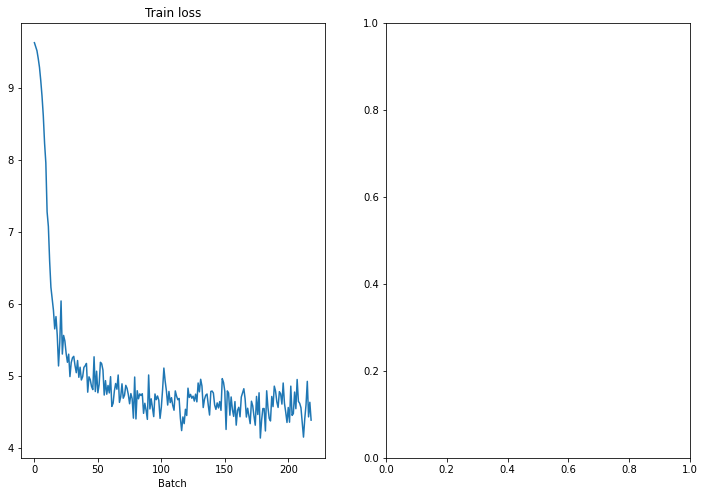

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
#losses = {"train_losses": [], "valid_losses": []}
import torch.optim as optim
optimizer =  optim.AdamW(model.parameters(), lr=1e-4)# favourite one
criterion = nn.CrossEntropyLoss(ignore_index=0)

epochs = 40
clip = 0.5
alpha_c =1
train_history=[]
valid_history  = []
best_valid_loss = float('inf')
rep_loss_c = 0.1
for epoch in range(epochs):
  criterion = nn.CrossEntropyLoss(ignore_index=0)
  print(f"Start eposh #{epoch}")
  model.train()
  history = []
  i=0

  train_loss =0
  bath_size =0
  for train_batch in train_loader:

    captions= train_batch['inputs'].to(device)
    input = train_batch['img_codes'].to(device)
    mask =  train_batch['mask'].to(device)
    full_loss=0
    alpha_loss =0
    

    number_sent = random.randint(0,captions.size(1)-1)
    current_step = captions[:,number_sent,0]
    for word in range(captions.size(2)):
        optimizer.zero_grad()
        sents = captions[:,:,:word+1]
        mask_id = mask[:,:word+1]
        #print(sents.shape)
        
        #print( input.shape,sents.shape, mask.shape)
        output= model(input,sents, mask_id,number_sent)
        
        
        #rep_loss = (torch.argmax(output, dim =1)-current_step)
        #rep_loss = len(rep_loss[rep_loss==0])
        #current_step = torch.argmax(output[-1], dim =0)
        
        #print(output.shape, captions[:,number_sent, word+1].shape )
        loss = criterion(output, captions[:,number_sent, word+1])
        
        #full_loss+=(loss+rep_loss_c*rep_loss)
        full_loss+=loss
        #print(alpha.shape)
        #alpha_loss+= alpha
        if word ==captions.size(2)-2:
          break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    #full_loss +=  alpha_c * ((1. - alpha_loss) ** 2).mean()



        
      
    bath_size+=1
    train_loss += full_loss.item()/captions.size(2)

    history.append(full_loss.cpu().data.numpy()/captions.size(2))
    i+=1
    if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if len(train_history)>0 :
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if len(valid_history)>0:
                ax[1].plot(valid_history, label='general valid history')

                plt.legend()
            sent = generate_caption(img, t=5.)[0]
            print(Utoken(sent[0]))
            plt.show()
  
  train_history.append(train_loss/bath_size)

  model.eval()
  bath_size =0 
  val_loss=0 


  for valid_batch in valid_loader:
    captions= valid_batch['inputs'].to(device)
    input = valid_batch['img_codes'].to(device)
    mask =  valid_batch['mask'].to(device)
    full_loss=0
    alpha_loss =0
    number_sent = random.randint(0,captions.size(1)-1)
    for word in range(captions.size(2)):
        
        sents = captions[:,:,:word+1]
        mask_id = mask[:,:word+1]
        output = model(input,sents,mask_id,number_sent)
        
        loss = criterion(output, captions[:,number_sent, word+1])
        alpha_loss+= alpha_c*((1. - alpha) ** 2)
        full_loss+=loss
        if word ==captions.size(2)-2:
          break
    #full_loss += alpha_loss.mean()
    bath_size+=1
    val_loss += full_loss.item()/captions.size(2)
   

  if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/project dls/best-val-model.pt')
  valid_history.append(val_loss/bath_size)


  print(f"End eposh #{epoch}")
  



In [21]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
import sys
import os

py_file_location = "/content/gdrive/MyDrive/Colab Notebooks/project dls/"
sys.path.append(os.path.abspath(py_file_location))

from beheaded_inception3 import  BeheadedInception3

inception = BeheadedInception3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
model = CaptionNet(hidden_dim = 256)
#device = "cuda:0"
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/project dls//best-val-model.pt'))
model.to(device)

In [22]:
#!pip install scipy==1.2.0
from matplotlib import pyplot as plt
#from scipy.misc import imresize
%matplotlib inline
import cv2
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
#!pip install scipy==1.2.0
img = plt.imread('img.jpg')
#img = imresize(img, (299, 299)).astype('float32') / 255.
img = cv2.resize(src=img,
                       dsize=(299, 299),
                       interpolation=cv2.INTER_CUBIC).astype('float32') / 255.

--2021-08-19 05:15:25--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-08-19 05:15:25--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.006s  

2021-08-19 05:15:25 (8.26 MB/s) - ‘img.jpg’ saved [54731

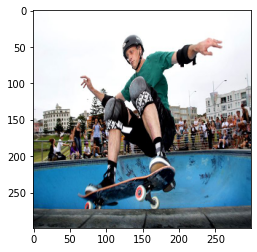

In [30]:
plt.imshow(img)

In [23]:
def Utoken(sent):
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(sent))

def generate_caption(image, caption_prefix=[101], 
                     t=1, sample=True, max_len=10):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    #device ='cpu'
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image[None])

        caption_prefix = list(caption_prefix)  
        words =[]    
        model.to(device)      
        

        input = torch.tensor(caption_prefix).unsqueeze(0).unsqueeze(0).to(device)

        for k in range(max_len):
            #print(vectors_neck.shape,input.shape)
            mask = torch.ones(input.size(2)).to(device)
            output= model(vectors_neck, input, mask,0)
            print(output.shape)
            words = torch.tensor([]).to(device)
           
            word = torch.argmax(output)
            #print(word.unsqueeze(0).unsqueeze(1).unsqueeze(1).shape, input.shape)
            input = torch.cat((input,word.unsqueeze(0).unsqueeze(1).unsqueeze(1).to(torch.int)), dim=2)
            #print(word.unsqueeze(0).unsqueeze(1).unsqueeze(1).shape, input.shape)
            if word==102:
              return input
              

        return input


sent = generate_caption(img, t=5.)[0]

print(Utoken(sent[0]))


/content/gdrive/MyDrive/Colab Notebooks/project dls/beheaded_inception3.py:16: UserWarning: Input isn't transformed
  else: warn("Input isn't transformed")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
torch.Size([1, 30522])
[CLS]ø a morrow talking a a a a vogue whimper
